## Imports & Config

In [1]:
import torch
import torch.nn as nn 
import cv2
import yaml
import numpy as np
from arcade_dataset import load_dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from model import VesselSegmentationModel

torch.cuda.empty_cache()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
config = yaml.load(open('model_overfit_config.yaml', 'r'), Loader=yaml.FullLoader)

In [4]:
modalities, H_in, W_in = config['input']['image_shape']

In [5]:
# Custom colors for classes
custom_colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
    'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan'
]

def get_color(category_id):
    return custom_colors[category_id % len(custom_colors)]

# Visualize the images and masks
def visualize_batch(batch, num_classes=25, num_images=1):
    fig, axes = plt.subplots(5, num_images, figsize=(20, 25))
    
    # Titles for each row
    row_titles = ['Original Image', 'Transformed Image (Top Hat)', 'Transformed Image (Canny Edge)', 'Mask', 'Separate Masks']
    
    for row_idx, row_title in enumerate(row_titles):
        # Display row title
        axes[row_idx, 0].set_ylabel(row_title, fontsize=16, labelpad=20)
        
        for i in range(num_images):
            ax = axes[row_idx, i]
            if row_idx == 0:  # Original Image
                ax.imshow(batch['original_image'][i].squeeze().cpu().numpy(), cmap='gray')
            elif row_idx == 1:  # Transformed Image (Top Hat)
                ax.imshow(batch['transformed_image'][i].permute(1, 2, 0).cpu().numpy()[:,:,1], cmap='gray')
            elif row_idx == 2:  # Transformed Image (Canny Edge)
                ax.imshow(batch['transformed_image'][i].permute(1, 2, 0).cpu().numpy()[:,:,2], cmap='gray')
            elif row_idx == 3:  # Mask
                ax.imshow(batch['masks'][i].squeeze().cpu().numpy(), cmap='gray')
            else:  # Separate Masks
                ax.imshow(batch['original_image'][i].squeeze().cpu().numpy(), cmap='gray')
                for class_id in range(num_classes):
                    mask = batch['separate_masks'][i, class_id].cpu().numpy()
                    if np.any(mask):
                        color = get_color(class_id)
                        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        for contour in contours:
                            ax.add_patch(patches.Polygon(contour.squeeze(), closed=True, fill=True, edgecolor=color, facecolor=color, alpha=0.3))
                            x, y, w, h = cv2.boundingRect(contour)
                            ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=0.8, edgecolor=color, facecolor='none'))
                            ax.text(x, y, str(class_id), fontsize=12, alpha=0.7, color=color)

            # Add labels to the title of each image
            if row_idx == 0:
                labels = batch['labels'][i].cpu().numpy()
                label_indices = np.where(labels == 1)[0]
                ax.set_title(f"Labels: {', '.join(map(str, label_indices))}", fontsize=12)
            
            ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

## Model Definition

In [6]:
model = VesselSegmentationModel.load_from_checkpoint('models/epoch=7-step=1000.ckpt')

## Overfit the model on a single batch

In [7]:
dataset = load_dataset(split='val')
next(iter(dataset)).keys()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True)

In [8]:
batch = next(iter(dataloader))

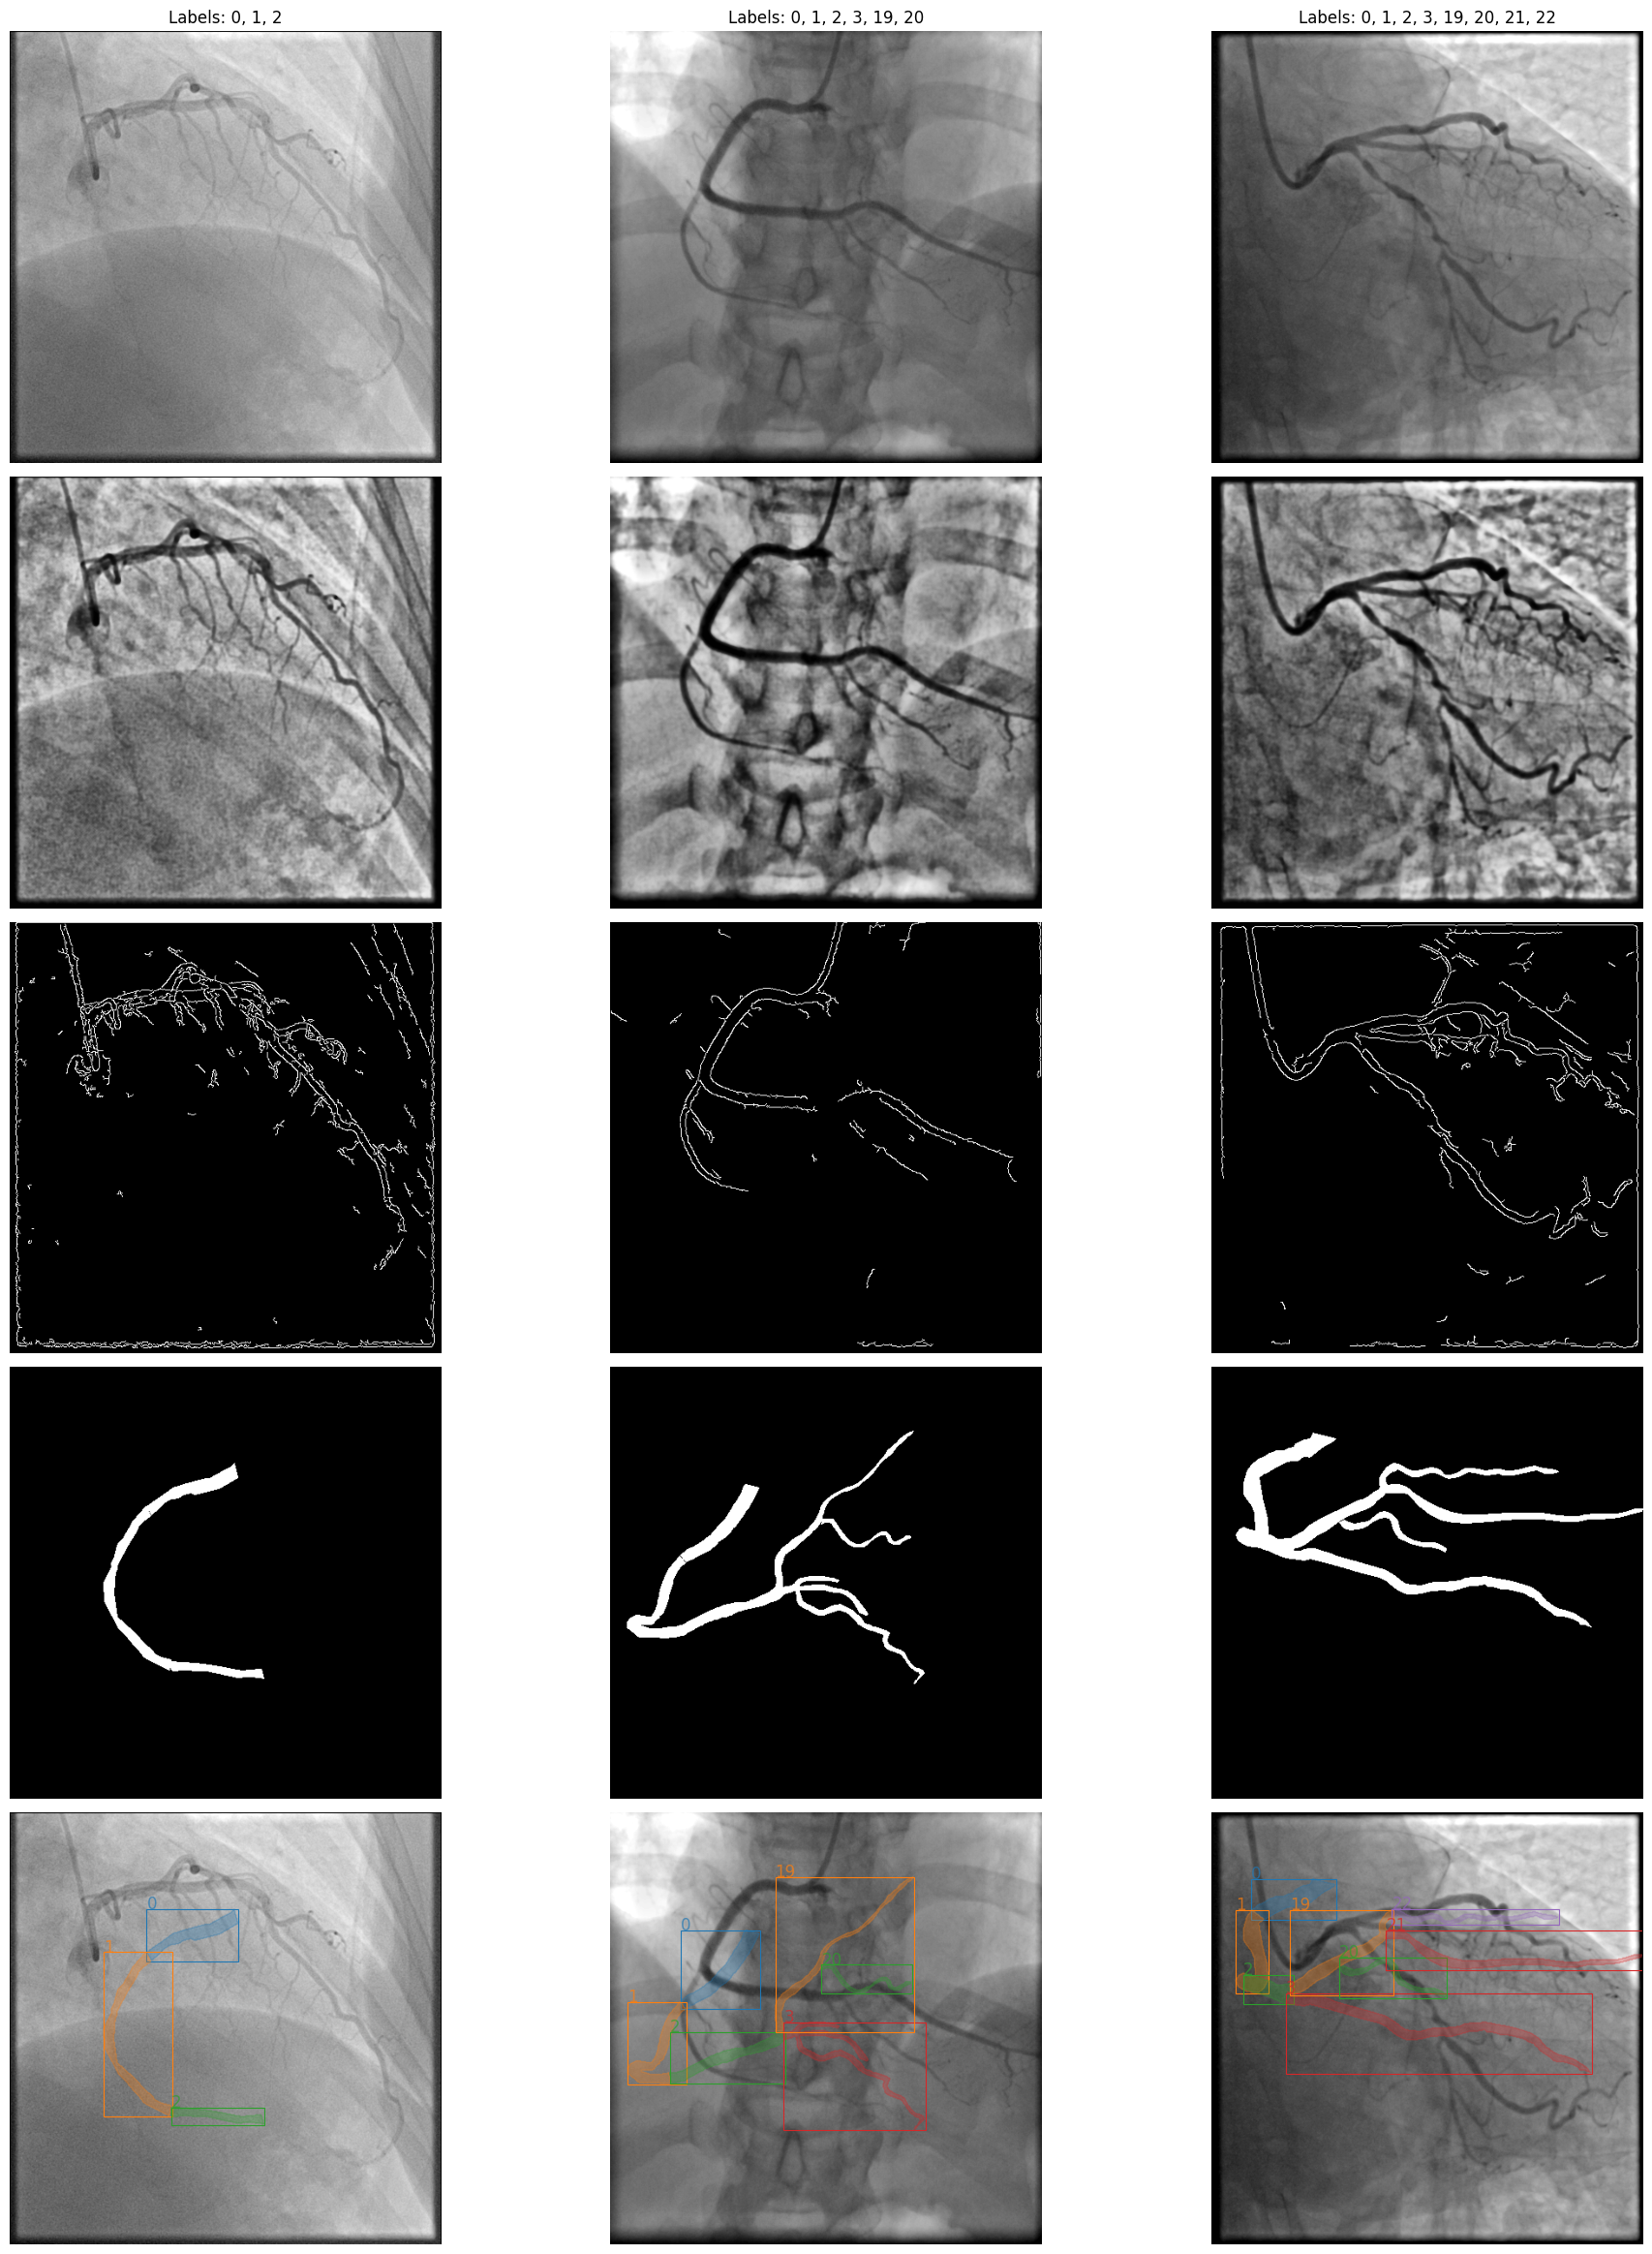

In [9]:
visualize_batch(batch, num_classes=25, num_images=3)

In [10]:
# optimizer = torch.optim.Adam(model.parameters(), lr=config['optimization']['learning_rate'] )
# losses = []
# progress_bar = tqdm(range(config['optimization']['epochs']))
# loss_metrics = [] 
# for epoch in progress_bar:
#     model.train()
#     x, y_gt = batch['transformed_image'].to(device), batch['separate_masks'].to(device)
#     labels = batch['labels'].to(device)
#     loss, kl_loss, reconstruction_loss, bce_loss, dice_loss, tversky_loss, focal_loss, classification_loss = model._loss(x, y_gt, labels)
#     loss_metrics.append((loss, kl_loss, reconstruction_loss, bce_loss, dice_loss, tversky_loss, focal_loss, classification_loss))
#     loss.backward()
#     losses.append(loss.item())
#     optimizer.step()
#     optimizer.zero_grad()
#     progress_bar.set_description(f"Loss: {loss.item():.4f} | KL Loss: {kl_loss.item():.4f} | Reconstruction Loss: {reconstruction_loss.item():.4f} | BCE Loss: {bce_loss.item():.4f} | Dice Loss: {dice_loss.item():.4f} | Tversky Loss: {tversky_loss.item():.4f} | Focal Loss: {focal_loss.item():.4f} | Classification Loss: {classification_loss.item():.4f}")
#     progress_bar.refresh()

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

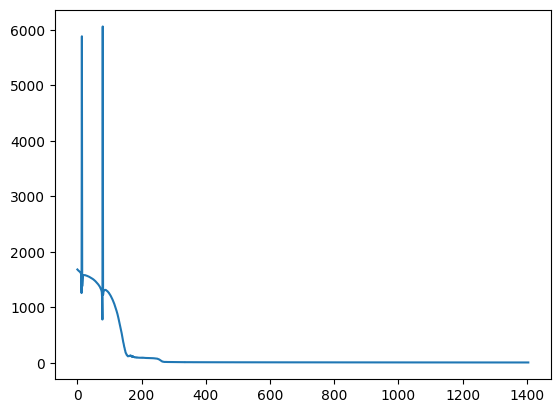

In [11]:
# plt.plot(losses[:])  

GT Labels: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1.], Predicted Labels: [False False False False False  True False False False False False False
  True False  True  True  True  True False False False False False False
  True]


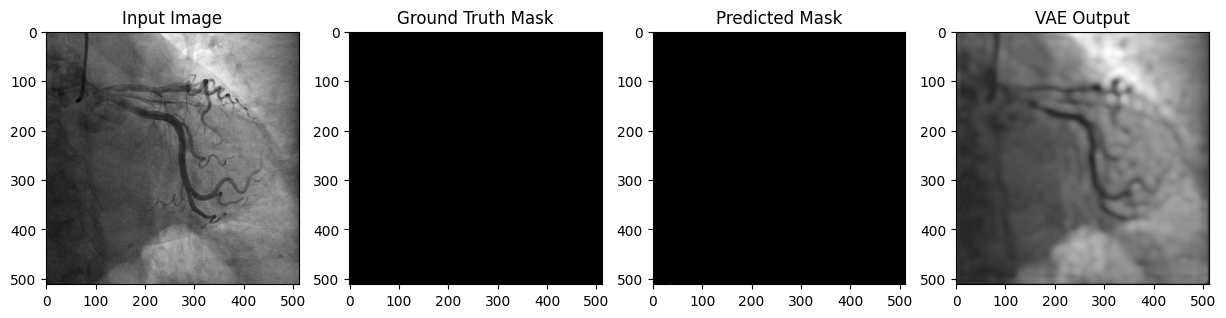

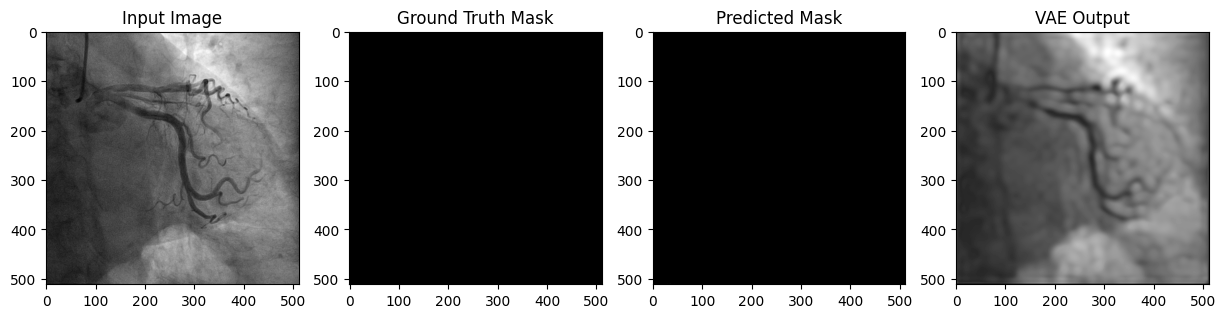

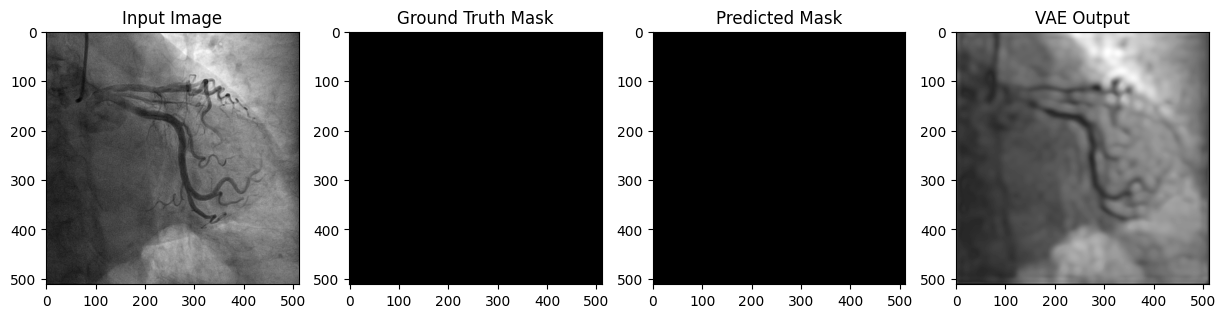

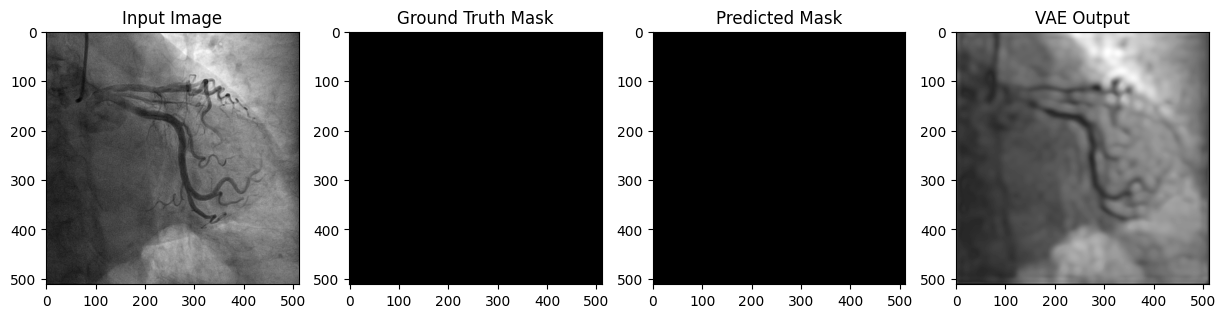

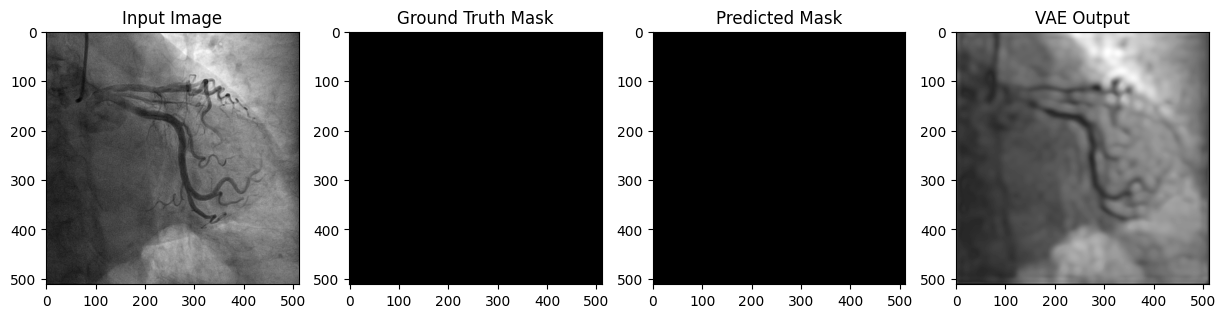

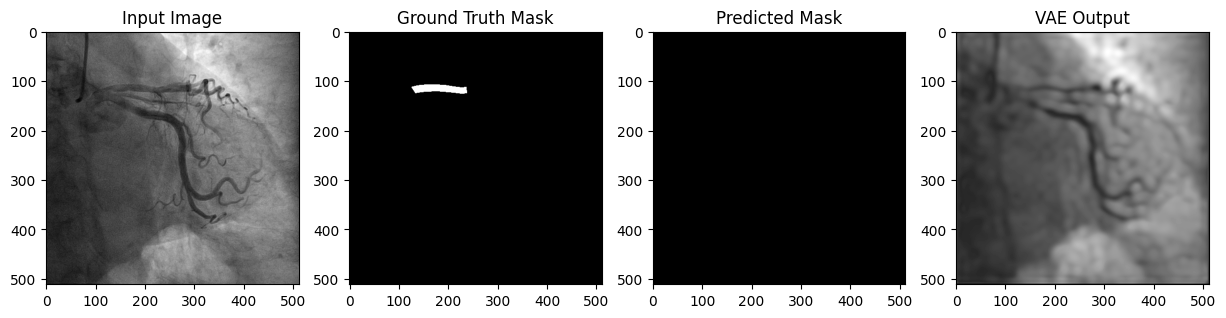

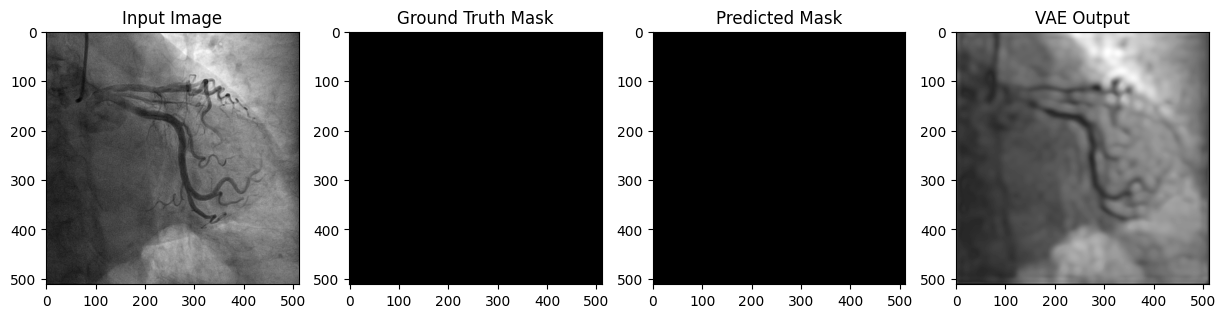

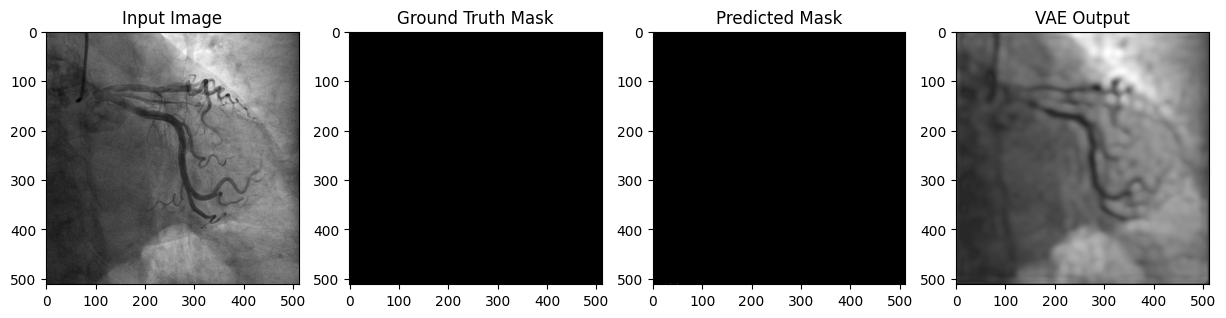

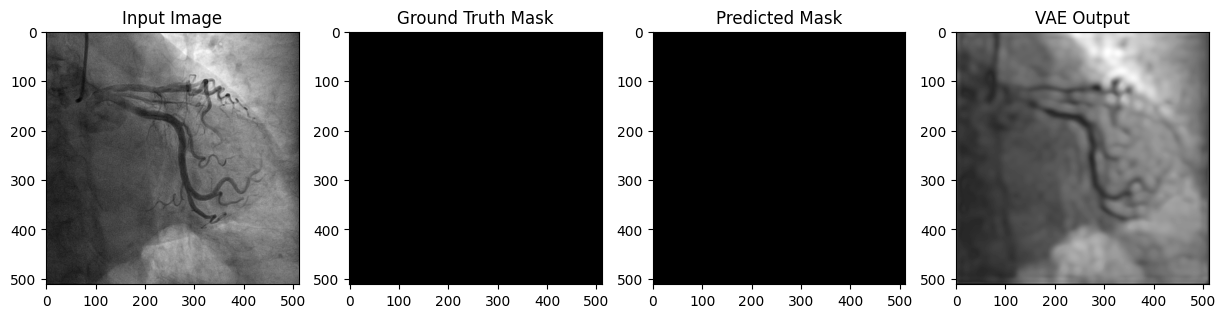

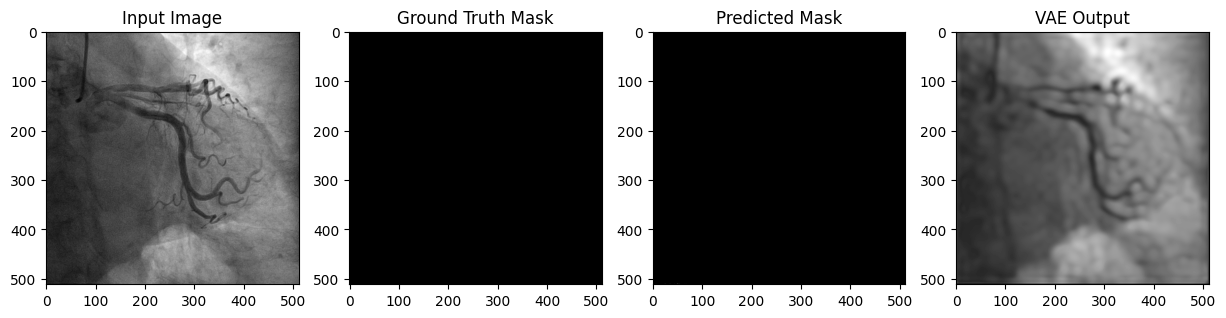

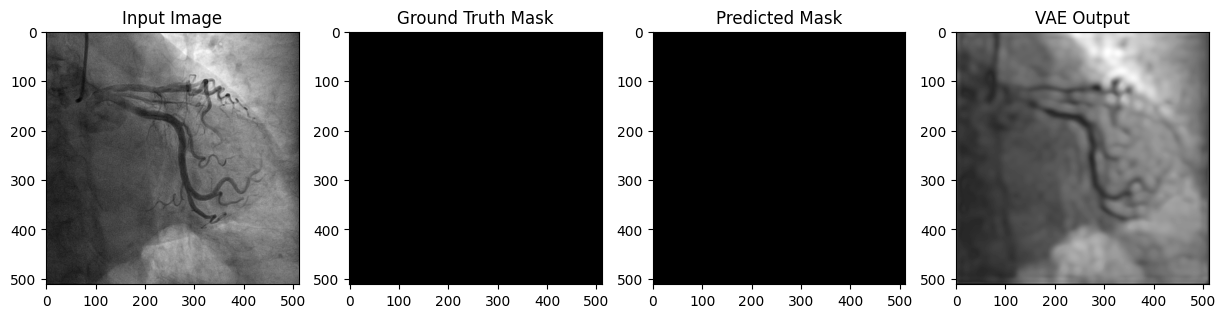

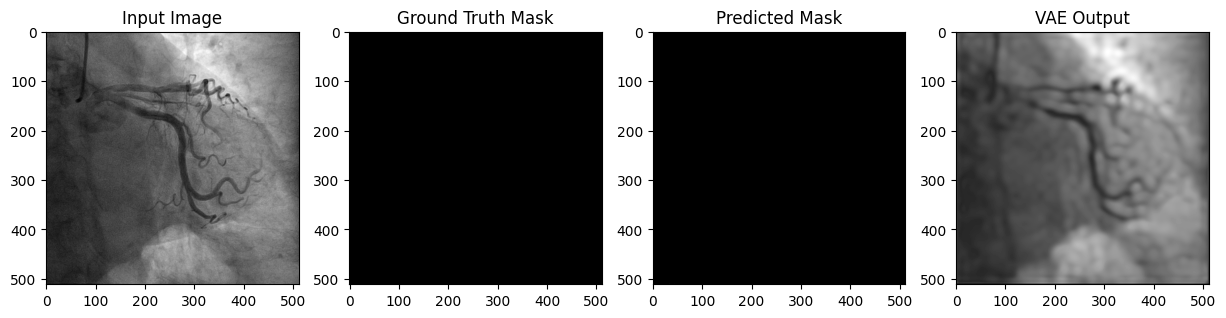

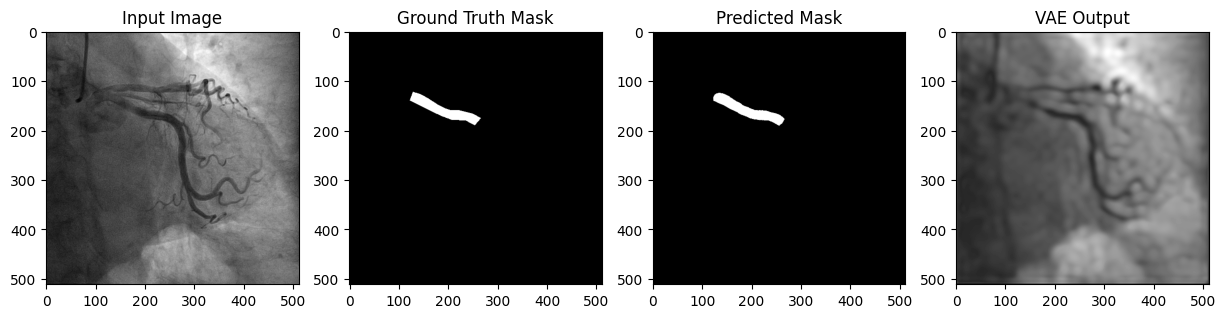

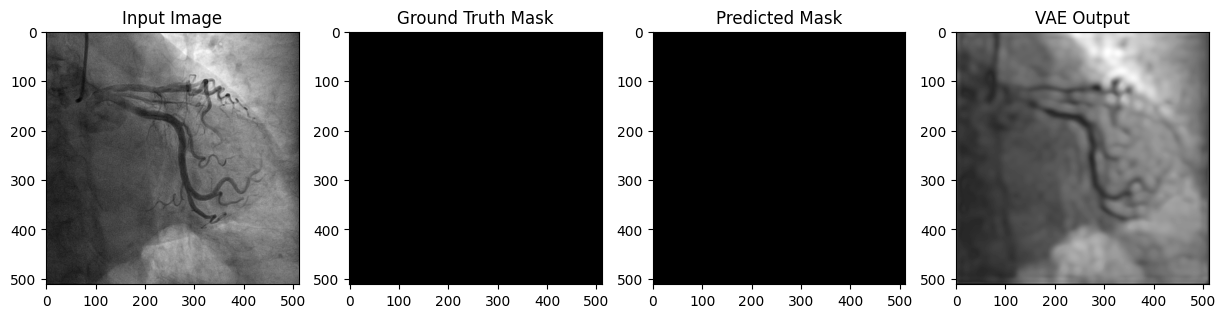

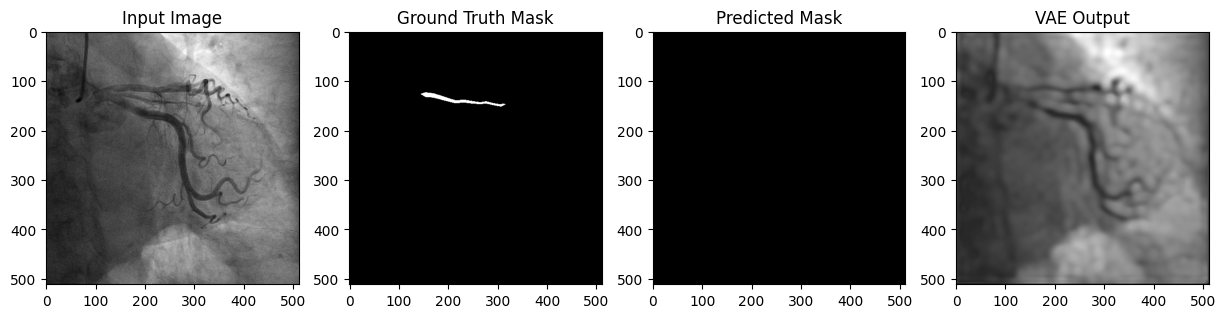

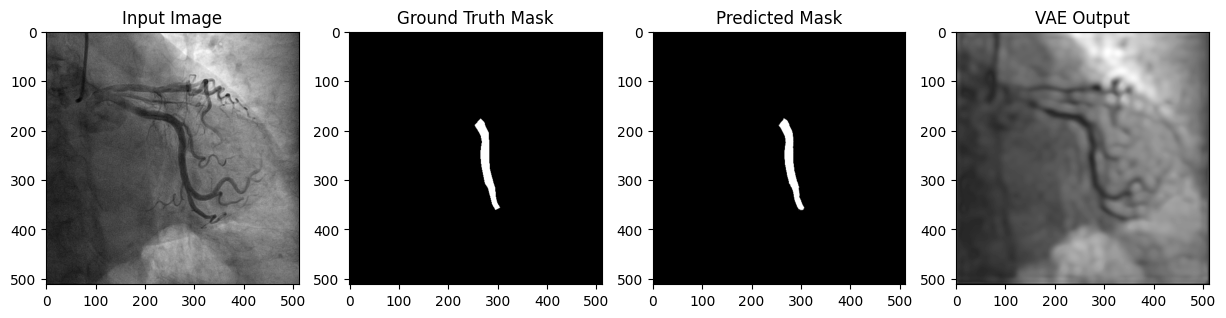

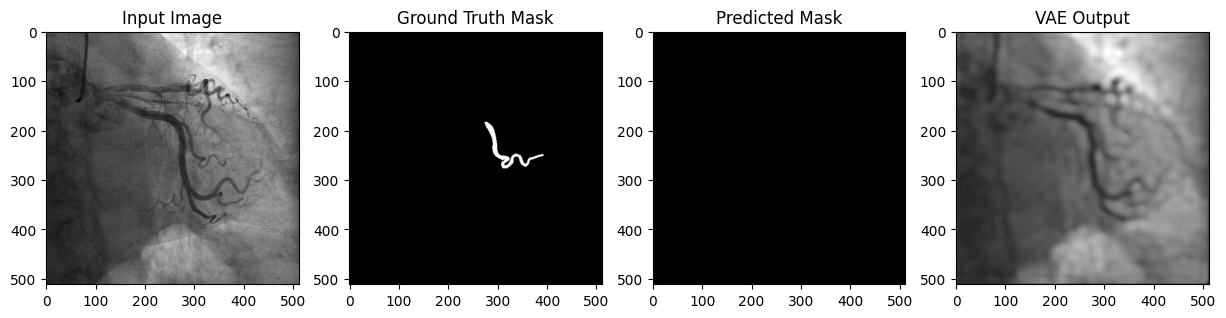

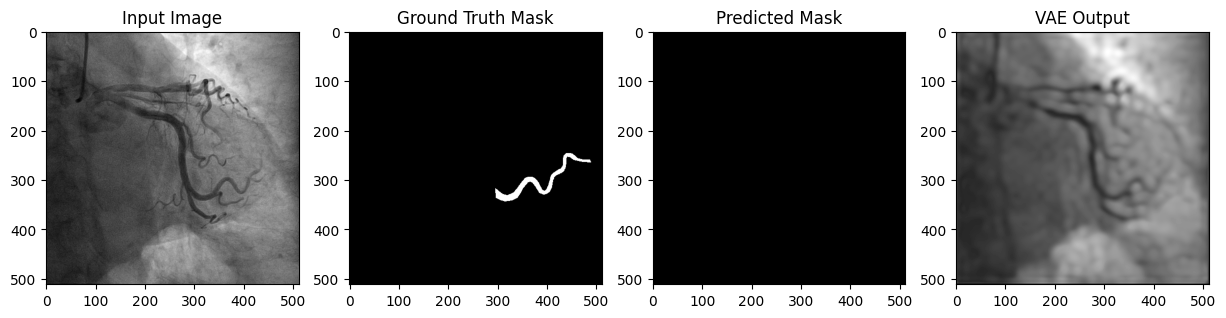

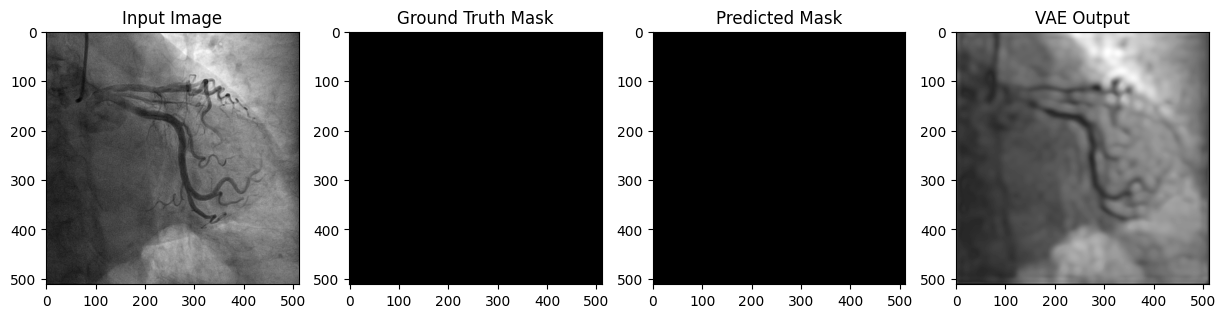

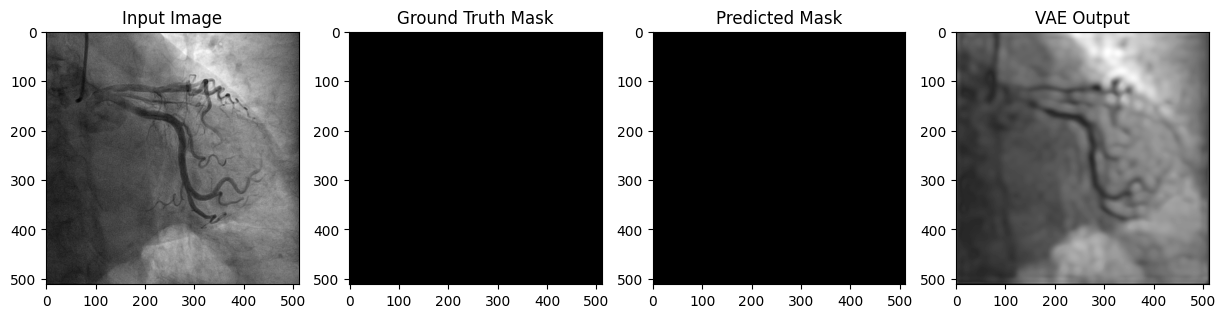

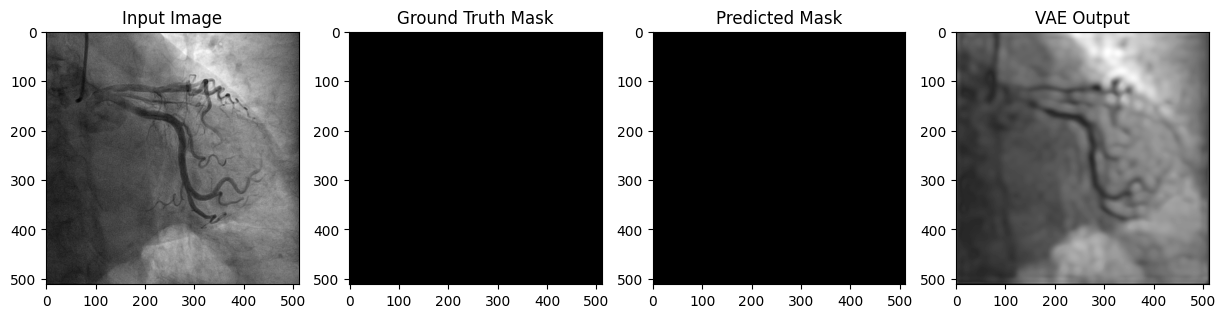

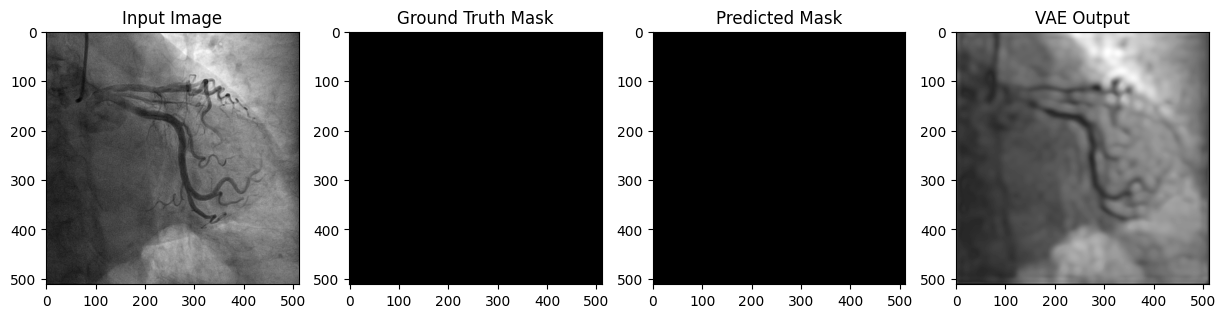

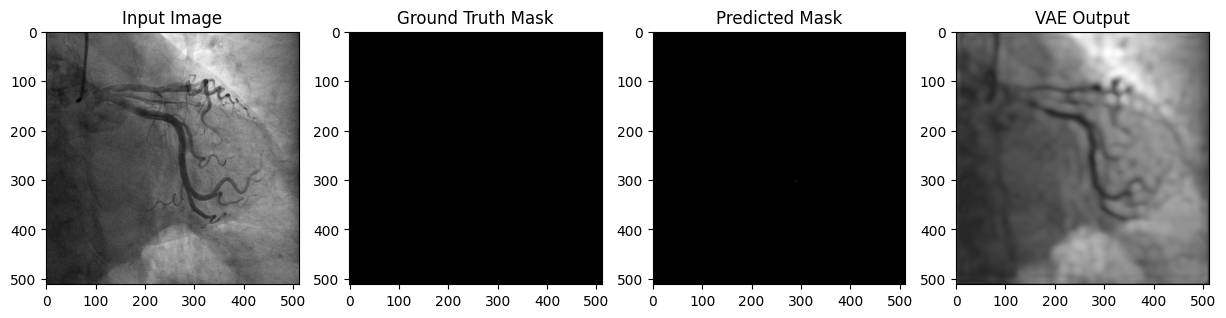

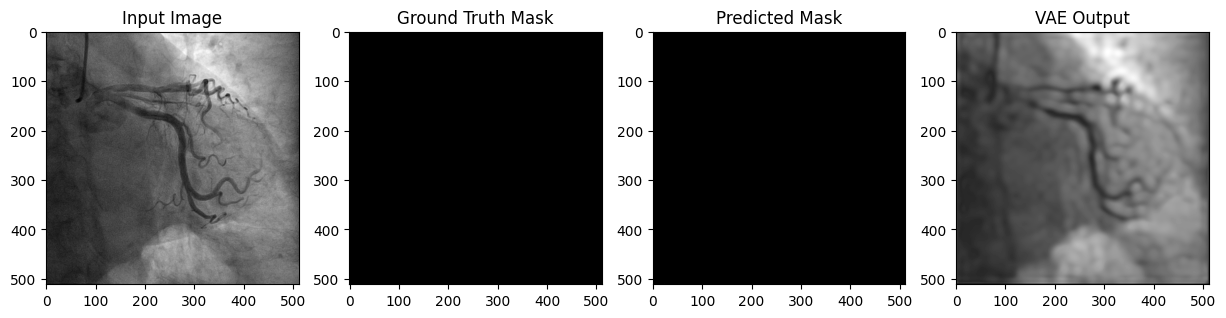

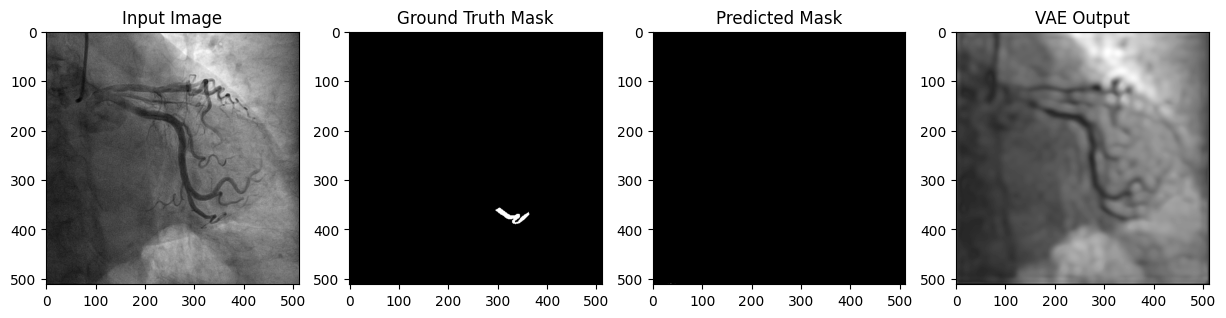

In [12]:
# Look at the output of the model
model.eval()
x, y_gt = batch['transformed_image'].to(device), batch['separate_masks'].to(device)
decoder_output, vae_output, _, labels, _ = model(x)
img = 0
print(f'GT Labels: {batch["labels"][1].cpu().numpy()}, Predicted Labels: {labels[1].detach().cpu().numpy() > 0.001}')

for c in range(25):
    plt.subplots(figsize=(15, 5), ncols=4)
    plt.subplot(1, 4, 1)
    plt.imshow(x[img, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title('Input Image')
    plt.subplot(1, 4, 2)
    plt.imshow(y_gt[img, c, :, :].cpu().numpy(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.subplot(1, 4, 3)
    plt.imshow(decoder_output[img, c, :, :].detach().cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')
    plt.subplot(1, 4, 4)
    plt.imshow(vae_output[img, 0, :, :].detach().cpu().numpy(), cmap='gray')
    plt.title('VAE Output')
    plt.show()